# Imports

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
import torch
from torch.autograd import Variable   
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
import linecache
import pandas as pd
from sklearn import preprocessing
from tqdm import trange
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
torch.cuda.set_device(2)
import time
import math

# Help functions

In [2]:
def line_show(line_batch, text=None):
    batch = line_batch["line"][0].shape[0]
    line1 = line_batch["line"][0].numpy().reshape(batch,-1)
    line2 = line_batch["line"][1].numpy().reshape(batch,-1)
    label = line_batch["label"].numpy()
    for i in range(batch):
        ax = plt.subplot(batch/2, 2, i+1)
        plt.subplots_adjust(wspace=0.2, hspace=1.5)
        plt.plot(line1[i])
        plt.plot(line2[i])
        plt.axis
        if text:
            ax.set_title(text+str(label[i]),fontsize=12,color='r')
    
def line_show_test(line_batch, text=None):
    line1 = line_batch[0].numpy().reshape(1,-1)
    line2 = line_batch[1].numpy().reshape(1,-1)
    plt.figure()
    plt.plot(line1[0])
    plt.plot(line2[0])
    if text:
        plt.title(text,fontsize='large',fontweight='bold') 
        
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    
    
def read_data_row(path, num):       
    return linecache.getline(path,num)

def normalization(l1, l2):
    pass

# Configuration Class

In [3]:
class Config():
    training_dir = "./data/train/"
    testing_dir = "./data/test/"
    train_batch_size = 32
    train_number_epochs = 30
    train_lr = 0.001
    train_m = 10.0

# Custom Dataset Class

In [4]:
class SkylineDataset(Dataset):
    
    def __init__(self,root,transform=None):
        self.root_path = root
        self.transform = transform
        self.filenames = os.listdir(self.root_path)
    def __getitem__(self,idx):
        filename = self.filenames[idx]
        file = read_data_row(os.path.join(self.root_path, filename), 1).strip().split(" ")
        line1 = np.array(list(map(int, file[0].split(',')))) # C*H*W = (1, 300, 1)
        if self.transform:
            line1 = Move()(line1)
            line1 = Rotate()(line1)
        line2 = np.array(list(map(int, file[1].split(','))))
        line = np.hstack((line1, line2))
        
        line_min, line_max = line.min(), line.max()
        line = (line-line_min)/(line_max-line_min)
        
        line1 = line[:300].reshape(1, 300, 1)
        line2 = line[300:].reshape(1, 300, 1)
        label = np.array(list(map(int, file[2])))
        sample = {"line":[line1, line2], "label":label}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return len(self.filenames)
    

In [5]:
class Rotate(object):
    def __call__(self, line):
        angle = random.randint(-6,6)
        pointx = len(line)//2
        pointy = line[pointx]
        angle = float(angle) * 3.1415  / float(180)
        x = np.arange(len(line))
        y = (x-pointx) * math.sin(angle) + (line - pointy) * math.cos(angle) + pointy
        
        return y


class Move(object):
    def __call__(self, line):
        delta = random.randint(-20,20)
        return line + delta
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        line, lable = sample['line'], sample['label']
        return {'line': [torch.from_numpy(line[0]).float(), torch.from_numpy(line[1]).float()],
                'label': torch.from_numpy(lable).float()}

In [6]:
# show
skyline_dataset = SkylineDataset(root=Config.training_dir, 
                                transform=transforms.Compose([ToTensor()]))


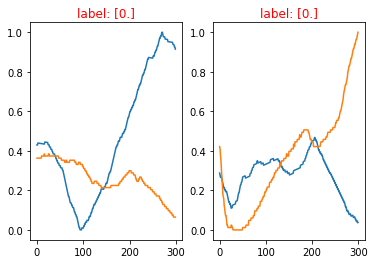

In [7]:
train_dataloader = DataLoader(skyline_dataset, 
                       shuffle=True,
                       batch_size = 2,
                       num_workers = 0
                       )
dataiter = iter(train_dataloader)
example_batch = next(dataiter)
line_show(example_batch, text="label: ")

# Neural Net Definition

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv1d(1, 48, kernel_size=5, stride=1, padding=2)
            nn.ReLU(inplace=False)
            nn.BatchNorm1d(48)
            nn.MaxPool1d(kernel_size=2, stride=2) # 48*150
            
            nn.Conv1d(48, 128, kernel_size=3, stride=1, padding=1)
            nn.ReLU(inplace=False)
            nn.BatchNorm1d(128)
            nn.MaxPool1d(kernel_size=2, stride=2) # 128*75
            
            nn.Conv1d(128, 1, kernel_size=3, stride=2, stride=2)
            nn.ReLU(inplace=False)
            nn.BatchNorm1d(1) # 1*36
        )
        
           
        
        self.classify = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(4),
            nn.MaxPool1d(kernel_size=2, stride=2)  # N*4*18
            
             nn.Conv1d(8, 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=2, stride=2)  # N*8*9
        )
        

        self.fc2 = nn.Sequential(
            nn.Linear(4, 1),
            nn.Sigmoid())

    def forward_once(self, x):

        output = self.fc1(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        output = torch.cat((output1, output2), 1)

        output = self.cnn1(output)
        output = self.cnn2(output)
        output = self.cnn3(output)
        output = self.cnn4(output)

        output = output.view(-1, 1, 4).contiguous()

        output = self.fc2(output)
        return output


In [9]:
from tensorboardX import SummaryWriter
dummy_input0 = torch.rand(32,1, 300) 
dummy_input1 = torch.rand(32,1, 300) 
model = SiameseNetwork()
with SummaryWriter(comment='SiameseNetwork') as w:
    w.add_graph(model, (dummy_input0, dummy_input1))

# Loss

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        euclidean_distance = F.threshold(euclidean_distance, 0.1, 0.0, inplace=False)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) # 所有batch的loss

        return loss_contrastive

# Train

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
skyline_dataset = SkylineDataset(root=Config.training_dir, 
                                transform=transforms.Compose([ToTensor()]))
train_dataloader = DataLoader(skyline_dataset, 
                       shuffle=True,
                       batch_size = Config.train_batch_size,
                       num_workers = 0
                       )

In [13]:
net = SiameseNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(),lr = Config.train_lr)

In [14]:
counter = []
loss_history = [] 
iteration_number= 0
best_acc = 0

In [15]:
def train(echoh):
    net.train()
    for i, data in enumerate(train_dataloader,0):
        line1 = data["line"][0].view(Config.train_batch_size, 1, -1)
        line2 = data["line"][1].view(Config.train_batch_size, 1, -1)
        label = data["label"]
        line1, line2 , label = line1.to(device), line2.to(device) , label.to(device)
        optimizer.zero_grad()
        output = net(line1,line2)
        loss_contrastive = criterion(output,label)
        loss_contrastive.backward()
        optimizer.step()
        
        if i %100 == 0 :
            print("Epoch {} | {} | Current loss {} ".format(epoch, i, loss_contrastive.item()))

In [16]:
def test(epoch):
    net.eval()
    
    with torch.no_grad():
        filenames = os.listdir(Config.testing_dir)
        acc_top20 = 0
        acc_top50 = 0
        acc_top100 = 0
        acc_top200 = 0
        
        for i in trange(100):
            index_target = random.randint(0, len(filenames)-1)
            file0 = read_data_row(os.path.join(Config.testing_dir, filenames[index_target]), 1).strip().split(" ")
            line0 = np.array(list(map(int, file0[0].split(','))))
            dist = []
            for f in filenames:
                file1 = read_data_row(os.path.join(Config.testing_dir, f), 1).strip().split(" ")
                line1 = np.array(list(map(int, file1[1].split(','))))
                line = np.hstack((line0, line1))
                line_min, line_max = line.min(), line.max()
                line = (line-line_min)/(line_max-line_min)
                line1 = torch.from_numpy(line[:300].reshape(1, 1, -1))
                line2 = torch.from_numpy(line[300:].reshape(1, 1, -1))
                
                output = net(Variable(line1).float().to(device), Variable(line2).float().to(device))
                dist.append(output.item())

            dist = pd.Series(np.array(dist)).sort_values(ascending=False)
            if index_target in dist[:20].index.tolist():
                acc_top20 += 1
            if index_target in dist[:50].index.tolist():
                acc_top50 += 1    
            if index_target in dist[:100].index.tolist():
                acc_top100 += 1
            if index_target in dist[:200].index.tolist():
                acc_top200 += 1
                
        acc_top20 /= 100.0
        acc_top50 /= 100.0
        acc_top100 /= 100.0
        acc_top200 /= 100.0
        acc_mean = (acc_top20+acc_top50+acc_top100+acc_top200) / 4
        print('epoch %d | acc_top20: %.3f | acc_top50: %.3f | acc_top100: %.3f | acc_top200: %.3f | acc_mean: %.3f' % (epoch, 
                                                                                                    acc_top20, 
                                                                                                    acc_top50,
                                                                                                    acc_top100,
                                                                                                    acc_top200,
                                                                                                    acc_mean))
        
        # saving
        global best_acc
        if acc_mean > best_acc:
            print("saving...")
            if not os.path.isdir('./checkpoint'):
                os.mkdir('./checkpoint')
            time_str = time.strftime("%Y-%m-%d %X",time.localtime())
            torch.save(net.state_dict(), './checkpoint/ckpt.{}.{:.2f}.pth'.format(time_str, acc_mean))
            best_acc = acc_mean
    

In [17]:
for epoch in range(0,30):
    train(epoch)
    test(epoch)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 0 | 0 | Current loss 0.6996501684188843 
Epoch 0 | 100 | Current loss 0.540132999420166 
Epoch 0 | 200 | Current loss 0.509812593460083 
Epoch 0 | 300 | Current loss 0.5519062280654907 
Epoch 0 | 400 | Current loss 0.5095047354698181 
Epoch 0 | 500 | Current loss 0.5373509526252747 
Epoch 0 | 600 | Current loss 0.5904581546783447 
Epoch 0 | 700 | Current loss 0.5655336976051331 
Epoch 0 | 800 | Current loss 0.5067805051803589 
Epoch 0 | 900 | Current loss 0.47447216510772705 
Epoch 0 | 1000 | Current loss 0.41593050956726074 
Epoch 0 | 1100 | Current loss 0.4382777810096741 
Epoch 0 | 1200 | Current loss 0.591771125793457 
Epoch 0 | 1300 | Current loss 0.47202637791633606 
Epoch 0 | 1400 | Current loss 0.4076029062271118 
Epoch 0 | 1500 | Current loss 0.4936365783214569 
Epoch 0 | 1600 | Current loss 0.36900198459625244 
Epoch 0 | 1700 | Current loss 0.4032285809516907 
Epoch 0 | 1800 | Current loss 0.41180017590522766 
Epoch 0 | 1900 | Current loss 0.45444923639297485 
Epoch 0 |

Epoch 0 | 16200 | Current loss 0.2748914957046509 
Epoch 0 | 16300 | Current loss 0.334890753030777 
Epoch 0 | 16400 | Current loss 0.23249563574790955 
Epoch 0 | 16500 | Current loss 0.35357415676116943 
Epoch 0 | 16600 | Current loss 0.17048867046833038 
Epoch 0 | 16700 | Current loss 0.1484232246875763 
Epoch 0 | 16800 | Current loss 0.2500161826610565 
Epoch 0 | 16900 | Current loss 0.15396389365196228 
Epoch 0 | 17000 | Current loss 0.23533931374549866 
Epoch 0 | 17100 | Current loss 0.1314316987991333 
Epoch 0 | 17200 | Current loss 0.29585427045822144 
Epoch 0 | 17300 | Current loss 0.28437960147857666 
Epoch 0 | 17400 | Current loss 0.29558998346328735 
Epoch 0 | 17500 | Current loss 0.3427469730377197 
Epoch 0 | 17600 | Current loss 0.24209028482437134 
Epoch 0 | 17700 | Current loss 0.49340006709098816 
Epoch 0 | 17800 | Current loss 0.24266186356544495 
Epoch 0 | 17900 | Current loss 0.27919742465019226 
Epoch 0 | 18000 | Current loss 0.4061064124107361 
Epoch 0 | 18100 | Cu

100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


epoch 0 | acc_top20: 0.840 | acc_top50: 0.940 | acc_top100: 0.970 | acc_top200: 0.990 | acc_mean: 0.935
saving...
Epoch 1 | 0 | Current loss 0.26907479763031006 
Epoch 1 | 100 | Current loss 0.31805551052093506 
Epoch 1 | 200 | Current loss 0.1028209701180458 
Epoch 1 | 300 | Current loss 0.2565907835960388 
Epoch 1 | 400 | Current loss 0.28220120072364807 
Epoch 1 | 500 | Current loss 0.15062448382377625 
Epoch 1 | 600 | Current loss 0.23921824991703033 
Epoch 1 | 700 | Current loss 0.2445032298564911 
Epoch 1 | 800 | Current loss 0.2773929238319397 
Epoch 1 | 900 | Current loss 0.16526851058006287 
Epoch 1 | 1000 | Current loss 0.18565398454666138 
Epoch 1 | 1100 | Current loss 0.2777329683303833 
Epoch 1 | 1200 | Current loss 0.2699297070503235 
Epoch 1 | 1300 | Current loss 0.2818495035171509 
Epoch 1 | 1400 | Current loss 0.1688580960035324 
Epoch 1 | 1500 | Current loss 0.5375403165817261 
Epoch 1 | 1600 | Current loss 0.28065821528434753 
Epoch 1 | 1700 | Current loss 0.19185277

Epoch 1 | 15900 | Current loss 0.2586381435394287 
Epoch 1 | 16000 | Current loss 0.17694854736328125 
Epoch 1 | 16100 | Current loss 0.3694417476654053 
Epoch 1 | 16200 | Current loss 0.28851786255836487 
Epoch 1 | 16300 | Current loss 0.11399774998426437 
Epoch 1 | 16400 | Current loss 0.20253674685955048 
Epoch 1 | 16500 | Current loss 0.10476517677307129 
Epoch 1 | 16600 | Current loss 0.13044792413711548 
Epoch 1 | 16700 | Current loss 0.15191049873828888 
Epoch 1 | 16800 | Current loss 0.16403013467788696 
Epoch 1 | 16900 | Current loss 0.17437848448753357 
Epoch 1 | 17000 | Current loss 0.12377256155014038 
Epoch 1 | 17100 | Current loss 0.06998015940189362 
Epoch 1 | 17200 | Current loss 0.1765773892402649 
Epoch 1 | 17300 | Current loss 0.15724673867225647 
Epoch 1 | 17400 | Current loss 0.24338001012802124 
Epoch 1 | 17500 | Current loss 0.14986515045166016 
Epoch 1 | 17600 | Current loss 0.17856144905090332 
Epoch 1 | 17700 | Current loss 0.06512689590454102 
Epoch 1 | 17800

100%|██████████| 100/100 [03:36<00:00,  2.16s/it]


epoch 1 | acc_top20: 0.850 | acc_top50: 0.960 | acc_top100: 0.980 | acc_top200: 0.980 | acc_mean: 0.943
saving...
Epoch 2 | 0 | Current loss 0.13604827225208282 
Epoch 2 | 100 | Current loss 0.13251391053199768 
Epoch 2 | 200 | Current loss 0.2089635580778122 
Epoch 2 | 300 | Current loss 0.09374789893627167 
Epoch 2 | 400 | Current loss 0.2059701681137085 
Epoch 2 | 500 | Current loss 0.47138452529907227 
Epoch 2 | 600 | Current loss 0.17955897748470306 
Epoch 2 | 700 | Current loss 0.17701560258865356 
Epoch 2 | 800 | Current loss 0.11744198948144913 
Epoch 2 | 900 | Current loss 0.15047171711921692 
Epoch 2 | 1000 | Current loss 0.15966324508190155 
Epoch 2 | 1100 | Current loss 0.16903722286224365 
Epoch 2 | 1200 | Current loss 0.37406736612319946 
Epoch 2 | 1300 | Current loss 0.05791313946247101 
Epoch 2 | 1400 | Current loss 0.10825547575950623 
Epoch 2 | 1500 | Current loss 0.5091503858566284 
Epoch 2 | 1600 | Current loss 0.3114491403102875 
Epoch 2 | 1700 | Current loss 0.285

Epoch 2 | 15900 | Current loss 0.15894921123981476 
Epoch 2 | 16000 | Current loss 0.3412722647190094 
Epoch 2 | 16100 | Current loss 0.41454631090164185 
Epoch 2 | 16200 | Current loss 0.13118217885494232 
Epoch 2 | 16300 | Current loss 0.21016144752502441 
Epoch 2 | 16400 | Current loss 0.18087005615234375 
Epoch 2 | 16500 | Current loss 0.12960022687911987 
Epoch 2 | 16600 | Current loss 0.11424362659454346 
Epoch 2 | 16700 | Current loss 0.10065194964408875 
Epoch 2 | 16800 | Current loss 0.17711885273456573 
Epoch 2 | 16900 | Current loss 0.13528195023536682 
Epoch 2 | 17000 | Current loss 0.1645873337984085 
Epoch 2 | 17100 | Current loss 0.3855927884578705 
Epoch 2 | 17200 | Current loss 0.19519361853599548 
Epoch 2 | 17300 | Current loss 0.07765898108482361 
Epoch 2 | 17400 | Current loss 0.24321094155311584 
Epoch 2 | 17500 | Current loss 0.2475816309452057 
Epoch 2 | 17600 | Current loss 0.22792881727218628 
Epoch 2 | 17700 | Current loss 0.17991942167282104 
Epoch 2 | 17800 

100%|██████████| 100/100 [03:32<00:00,  2.10s/it]


epoch 2 | acc_top20: 0.890 | acc_top50: 0.900 | acc_top100: 0.920 | acc_top200: 0.980 | acc_mean: 0.922
Epoch 3 | 0 | Current loss 0.2112681269645691 
Epoch 3 | 100 | Current loss 0.12276330590248108 
Epoch 3 | 200 | Current loss 0.0606803372502327 
Epoch 3 | 300 | Current loss 0.1063966304063797 
Epoch 3 | 400 | Current loss 0.0820045918226242 
Epoch 3 | 500 | Current loss 0.13806979358196259 
Epoch 3 | 600 | Current loss 0.2323148548603058 
Epoch 3 | 700 | Current loss 0.08486002683639526 
Epoch 3 | 800 | Current loss 0.263012170791626 
Epoch 3 | 900 | Current loss 0.05486612766981125 
Epoch 3 | 1000 | Current loss 0.18234890699386597 
Epoch 3 | 1100 | Current loss 0.2688004672527313 
Epoch 3 | 1200 | Current loss 0.14636850357055664 
Epoch 3 | 1300 | Current loss 0.35901254415512085 
Epoch 3 | 1400 | Current loss 0.2802354395389557 
Epoch 3 | 1500 | Current loss 0.2011633813381195 
Epoch 3 | 1600 | Current loss 0.12033024430274963 
Epoch 3 | 1700 | Current loss 0.3084115982055664 
E

Epoch 3 | 15900 | Current loss 0.1209765076637268 
Epoch 3 | 16000 | Current loss 0.13293740153312683 
Epoch 3 | 16100 | Current loss 0.1197412759065628 
Epoch 3 | 16200 | Current loss 0.07560717314481735 
Epoch 3 | 16300 | Current loss 0.2711479961872101 
Epoch 3 | 16400 | Current loss 0.15010666847229004 
Epoch 3 | 16500 | Current loss 0.12277515977621078 
Epoch 3 | 16600 | Current loss 0.0914117842912674 
Epoch 3 | 16700 | Current loss 0.0775136947631836 
Epoch 3 | 16800 | Current loss 0.19080020487308502 
Epoch 3 | 16900 | Current loss 0.13158287107944489 
Epoch 3 | 17000 | Current loss 0.12694483995437622 
Epoch 3 | 17100 | Current loss 0.08831991255283356 
Epoch 3 | 17200 | Current loss 0.25313448905944824 
Epoch 3 | 17300 | Current loss 0.29405373334884644 
Epoch 3 | 17400 | Current loss 0.09136870503425598 
Epoch 3 | 17500 | Current loss 0.1372988224029541 
Epoch 3 | 17600 | Current loss 0.2755068838596344 
Epoch 3 | 17700 | Current loss 0.2667684555053711 
Epoch 3 | 17800 | Cu

100%|██████████| 100/100 [03:32<00:00,  2.17s/it]


epoch 3 | acc_top20: 0.850 | acc_top50: 0.940 | acc_top100: 0.970 | acc_top200: 0.980 | acc_mean: 0.935
Epoch 4 | 0 | Current loss 0.0945751816034317 
Epoch 4 | 100 | Current loss 0.2941647171974182 
Epoch 4 | 200 | Current loss 0.07571707665920258 
Epoch 4 | 300 | Current loss 0.24922218918800354 
Epoch 4 | 400 | Current loss 0.04315020889043808 
Epoch 4 | 500 | Current loss 0.10143131017684937 
Epoch 4 | 600 | Current loss 0.3566286563873291 
Epoch 4 | 700 | Current loss 0.08427117764949799 
Epoch 4 | 800 | Current loss 0.19862164556980133 
Epoch 4 | 900 | Current loss 0.11180815100669861 
Epoch 4 | 1000 | Current loss 0.27528470754623413 
Epoch 4 | 1100 | Current loss 0.2017962634563446 
Epoch 4 | 1200 | Current loss 0.10037457942962646 
Epoch 4 | 1300 | Current loss 0.07983802258968353 
Epoch 4 | 1400 | Current loss 0.11731746792793274 
Epoch 4 | 1500 | Current loss 0.23205795884132385 
Epoch 4 | 1600 | Current loss 0.07919856905937195 
Epoch 4 | 1700 | Current loss 0.1796745061874

Epoch 4 | 15900 | Current loss 0.04923570528626442 
Epoch 4 | 16000 | Current loss 0.17555275559425354 
Epoch 4 | 16100 | Current loss 0.14556793868541718 
Epoch 4 | 16200 | Current loss 0.14640411734580994 
Epoch 4 | 16300 | Current loss 0.2086142897605896 
Epoch 4 | 16400 | Current loss 0.2919880151748657 
Epoch 4 | 16500 | Current loss 0.22776482999324799 
Epoch 4 | 16600 | Current loss 0.11437062919139862 
Epoch 4 | 16700 | Current loss 0.05740286409854889 
Epoch 4 | 16800 | Current loss 0.2774931490421295 
Epoch 4 | 16900 | Current loss 0.2787977159023285 
Epoch 4 | 17000 | Current loss 0.2790546417236328 
Epoch 4 | 17100 | Current loss 0.13098058104515076 
Epoch 4 | 17200 | Current loss 0.060426872223615646 
Epoch 4 | 17300 | Current loss 0.16255582869052887 
Epoch 4 | 17400 | Current loss 0.06567572057247162 
Epoch 4 | 17500 | Current loss 0.2059316635131836 
Epoch 4 | 17600 | Current loss 0.15725862979888916 
Epoch 4 | 17700 | Current loss 0.1237366795539856 
Epoch 4 | 17800 | 

100%|██████████| 100/100 [03:27<00:00,  2.09s/it]


epoch 4 | acc_top20: 0.850 | acc_top50: 0.910 | acc_top100: 0.920 | acc_top200: 0.980 | acc_mean: 0.915
Epoch 5 | 0 | Current loss 0.09950899332761765 
Epoch 5 | 100 | Current loss 0.13063287734985352 
Epoch 5 | 200 | Current loss 0.2676616311073303 
Epoch 5 | 300 | Current loss 0.1828870177268982 
Epoch 5 | 400 | Current loss 0.27602702379226685 
Epoch 5 | 500 | Current loss 0.11599238961935043 
Epoch 5 | 600 | Current loss 0.1868707686662674 
Epoch 5 | 700 | Current loss 0.10383562743663788 
Epoch 5 | 800 | Current loss 0.11698387563228607 
Epoch 5 | 900 | Current loss 0.21757854521274567 
Epoch 5 | 1000 | Current loss 0.09427753835916519 
Epoch 5 | 1100 | Current loss 0.056474510580301285 
Epoch 5 | 1200 | Current loss 0.38237228989601135 
Epoch 5 | 1300 | Current loss 0.10848741233348846 
Epoch 5 | 1400 | Current loss 0.19767038524150848 
Epoch 5 | 1500 | Current loss 0.2364855706691742 
Epoch 5 | 1600 | Current loss 0.09558753669261932 
Epoch 5 | 1700 | Current loss 0.196270674467

Epoch 5 | 15900 | Current loss 0.23317287862300873 
Epoch 5 | 16000 | Current loss 0.11494535207748413 
Epoch 5 | 16100 | Current loss 0.10246478021144867 
Epoch 5 | 16200 | Current loss 0.10047155618667603 
Epoch 5 | 16300 | Current loss 0.1718290001153946 
Epoch 5 | 16400 | Current loss 0.3373355269432068 
Epoch 5 | 16500 | Current loss 0.07367179542779922 
Epoch 5 | 16600 | Current loss 0.0843871608376503 
Epoch 5 | 16700 | Current loss 0.21191880106925964 
Epoch 5 | 16800 | Current loss 0.12423840165138245 
Epoch 5 | 16900 | Current loss 0.2540397047996521 
Epoch 5 | 17000 | Current loss 0.2837487459182739 
Epoch 5 | 17100 | Current loss 0.10374262928962708 
Epoch 5 | 17200 | Current loss 0.10013608634471893 
Epoch 5 | 17300 | Current loss 0.18226027488708496 
Epoch 5 | 17400 | Current loss 0.20824426412582397 
Epoch 5 | 17500 | Current loss 0.1999818980693817 
Epoch 5 | 17600 | Current loss 0.052776023745536804 
Epoch 5 | 17700 | Current loss 0.11719326674938202 
Epoch 5 | 17800 |

100%|██████████| 100/100 [03:35<00:00,  2.15s/it]


epoch 5 | acc_top20: 0.900 | acc_top50: 0.940 | acc_top100: 0.960 | acc_top200: 0.970 | acc_mean: 0.942
Epoch 6 | 0 | Current loss 0.14368008077144623 
Epoch 6 | 100 | Current loss 0.12673327326774597 
Epoch 6 | 200 | Current loss 0.16140201687812805 
Epoch 6 | 300 | Current loss 0.1277671605348587 
Epoch 6 | 400 | Current loss 0.32897958159446716 
Epoch 6 | 500 | Current loss 0.156968891620636 
Epoch 6 | 600 | Current loss 0.18555322289466858 
Epoch 6 | 700 | Current loss 0.08976089209318161 
Epoch 6 | 800 | Current loss 0.19246062636375427 
Epoch 6 | 900 | Current loss 0.19541215896606445 
Epoch 6 | 1000 | Current loss 0.11104614287614822 
Epoch 6 | 1100 | Current loss 0.22486504912376404 
Epoch 6 | 1200 | Current loss 0.13760773837566376 
Epoch 6 | 1300 | Current loss 0.1556607037782669 
Epoch 6 | 1400 | Current loss 0.037821635603904724 
Epoch 6 | 1500 | Current loss 0.04774931073188782 
Epoch 6 | 1600 | Current loss 0.1950010508298874 
Epoch 6 | 1700 | Current loss 0.0793813019990

Epoch 6 | 15900 | Current loss 0.06328531354665756 
Epoch 6 | 16000 | Current loss 0.17212052643299103 
Epoch 6 | 16100 | Current loss 0.17355503141880035 
Epoch 6 | 16200 | Current loss 0.1432696282863617 
Epoch 6 | 16300 | Current loss 0.056049395352602005 
Epoch 6 | 16400 | Current loss 0.19787345826625824 
Epoch 6 | 16500 | Current loss 0.03601010888814926 
Epoch 6 | 16600 | Current loss 0.5173129439353943 
Epoch 6 | 16700 | Current loss 0.24032998085021973 
Epoch 6 | 16800 | Current loss 0.2823774218559265 
Epoch 6 | 16900 | Current loss 0.1626824140548706 
Epoch 6 | 17000 | Current loss 0.10644175112247467 
Epoch 6 | 17100 | Current loss 0.20892183482646942 
Epoch 6 | 17200 | Current loss 0.1745593398809433 
Epoch 6 | 17300 | Current loss 0.05310439318418503 
Epoch 6 | 17400 | Current loss 0.06493677198886871 
Epoch 6 | 17500 | Current loss 0.2108248472213745 
Epoch 6 | 17600 | Current loss 0.24362972378730774 
Epoch 6 | 17700 | Current loss 0.14101654291152954 
Epoch 6 | 17800 |

100%|██████████| 100/100 [03:24<00:00,  2.11s/it]


epoch 6 | acc_top20: 0.910 | acc_top50: 0.920 | acc_top100: 0.930 | acc_top200: 0.990 | acc_mean: 0.938
Epoch 7 | 0 | Current loss 0.22775603830814362 
Epoch 7 | 100 | Current loss 0.15546642243862152 
Epoch 7 | 200 | Current loss 0.21707683801651 
Epoch 7 | 300 | Current loss 0.16114568710327148 
Epoch 7 | 400 | Current loss 0.09789338707923889 
Epoch 7 | 500 | Current loss 0.265058308839798 
Epoch 7 | 600 | Current loss 0.20839905738830566 
Epoch 7 | 700 | Current loss 0.060168225318193436 
Epoch 7 | 800 | Current loss 0.05134928226470947 
Epoch 7 | 900 | Current loss 0.14858323335647583 
Epoch 7 | 1000 | Current loss 0.06748335063457489 
Epoch 7 | 1100 | Current loss 0.12094100564718246 
Epoch 7 | 1200 | Current loss 0.06846243143081665 
Epoch 7 | 1300 | Current loss 0.10584564507007599 
Epoch 7 | 1400 | Current loss 0.17699740827083588 
Epoch 7 | 1500 | Current loss 0.1858867108821869 
Epoch 7 | 1600 | Current loss 0.23056690394878387 
Epoch 7 | 1700 | Current loss 0.08242614567279

Epoch 7 | 15900 | Current loss 0.07002130150794983 
Epoch 7 | 16000 | Current loss 0.1023172065615654 
Epoch 7 | 16100 | Current loss 0.0687524676322937 
Epoch 7 | 16200 | Current loss 0.4461889863014221 
Epoch 7 | 16300 | Current loss 0.18642324209213257 
Epoch 7 | 16400 | Current loss 0.15672263503074646 
Epoch 7 | 16500 | Current loss 0.2311844676733017 
Epoch 7 | 16600 | Current loss 0.1280023157596588 
Epoch 7 | 16700 | Current loss 0.11387106776237488 
Epoch 7 | 16800 | Current loss 0.06186032295227051 
Epoch 7 | 16900 | Current loss 0.028657082468271255 
Epoch 7 | 17000 | Current loss 0.17738595604896545 
Epoch 7 | 17100 | Current loss 0.13983285427093506 
Epoch 7 | 17200 | Current loss 0.1344892680644989 
Epoch 7 | 17300 | Current loss 0.18976864218711853 
Epoch 7 | 17400 | Current loss 0.2494686245918274 
Epoch 7 | 17500 | Current loss 0.04604489356279373 
Epoch 7 | 17600 | Current loss 0.16466785967350006 
Epoch 7 | 17700 | Current loss 0.2794007360935211 
Epoch 7 | 17800 | C

100%|██████████| 100/100 [03:29<00:00,  2.11s/it]


epoch 7 | acc_top20: 0.930 | acc_top50: 0.960 | acc_top100: 0.980 | acc_top200: 1.000 | acc_mean: 0.968
saving...
Epoch 8 | 0 | Current loss 0.134312242269516 
Epoch 8 | 100 | Current loss 0.054213106632232666 
Epoch 8 | 200 | Current loss 0.06402632594108582 
Epoch 8 | 300 | Current loss 0.13792863488197327 
Epoch 8 | 400 | Current loss 0.0759422779083252 
Epoch 8 | 500 | Current loss 0.13841916620731354 
Epoch 8 | 600 | Current loss 0.2937805950641632 
Epoch 8 | 700 | Current loss 0.1619584858417511 
Epoch 8 | 800 | Current loss 0.2212112843990326 
Epoch 8 | 900 | Current loss 0.41791999340057373 
Epoch 8 | 1000 | Current loss 0.07558953762054443 
Epoch 8 | 1100 | Current loss 0.16688218712806702 
Epoch 8 | 1200 | Current loss 0.2034478783607483 
Epoch 8 | 1300 | Current loss 0.1456332504749298 
Epoch 8 | 1400 | Current loss 0.033749546855688095 
Epoch 8 | 1500 | Current loss 0.0629281997680664 
Epoch 8 | 1600 | Current loss 0.1430397927761078 
Epoch 8 | 1700 | Current loss 0.2050279

Epoch 8 | 15900 | Current loss 0.15824684500694275 
Epoch 8 | 16000 | Current loss 0.09099684655666351 
Epoch 8 | 16100 | Current loss 0.20210051536560059 
Epoch 8 | 16200 | Current loss 0.11737224459648132 
Epoch 8 | 16300 | Current loss 0.07157722860574722 
Epoch 8 | 16400 | Current loss 0.16933177411556244 
Epoch 8 | 16500 | Current loss 0.08432371914386749 
Epoch 8 | 16600 | Current loss 0.0570664256811142 
Epoch 8 | 16700 | Current loss 0.025722865015268326 
Epoch 8 | 16800 | Current loss 0.11113086342811584 
Epoch 8 | 16900 | Current loss 0.24636059999465942 
Epoch 8 | 17000 | Current loss 0.20587246119976044 
Epoch 8 | 17100 | Current loss 0.23969370126724243 
Epoch 8 | 17200 | Current loss 0.19575120508670807 
Epoch 8 | 17300 | Current loss 0.23777511715888977 
Epoch 8 | 17400 | Current loss 0.19221943616867065 
Epoch 8 | 17500 | Current loss 0.1737927794456482 
Epoch 8 | 17600 | Current loss 0.2072906196117401 
Epoch 8 | 17700 | Current loss 0.09212297946214676 
Epoch 8 | 1780

100%|██████████| 100/100 [03:33<00:00,  2.16s/it]


epoch 8 | acc_top20: 0.940 | acc_top50: 0.960 | acc_top100: 1.000 | acc_top200: 1.000 | acc_mean: 0.975
saving...
Epoch 9 | 0 | Current loss 0.1544724553823471 
Epoch 9 | 100 | Current loss 0.17632773518562317 
Epoch 9 | 200 | Current loss 0.13285361230373383 
Epoch 9 | 300 | Current loss 0.1383708119392395 
Epoch 9 | 400 | Current loss 0.24479711055755615 
Epoch 9 | 500 | Current loss 0.1003333330154419 
Epoch 9 | 600 | Current loss 0.16943275928497314 
Epoch 9 | 700 | Current loss 0.10124023258686066 
Epoch 9 | 800 | Current loss 0.0968513935804367 
Epoch 9 | 900 | Current loss 0.09568848460912704 
Epoch 9 | 1000 | Current loss 0.10301238298416138 
Epoch 9 | 1100 | Current loss 0.1513131558895111 
Epoch 9 | 1200 | Current loss 0.08139094710350037 
Epoch 9 | 1300 | Current loss 0.13192340731620789 
Epoch 9 | 1400 | Current loss 0.27701911330223083 
Epoch 9 | 1500 | Current loss 0.06570965051651001 
Epoch 9 | 1600 | Current loss 0.06398013979196548 
Epoch 9 | 1700 | Current loss 0.2309

Epoch 9 | 15900 | Current loss 0.0525575689971447 
Epoch 9 | 16000 | Current loss 0.11441066861152649 
Epoch 9 | 16100 | Current loss 0.07084359228610992 
Epoch 9 | 16200 | Current loss 0.09458931535482407 
Epoch 9 | 16300 | Current loss 0.0762624591588974 
Epoch 9 | 16400 | Current loss 0.06207992509007454 
Epoch 9 | 16500 | Current loss 0.04531659930944443 
Epoch 9 | 16600 | Current loss 0.12370996177196503 
Epoch 9 | 16700 | Current loss 0.29975128173828125 
Epoch 9 | 16800 | Current loss 0.14131289720535278 
Epoch 9 | 16900 | Current loss 0.11149820685386658 
Epoch 9 | 17000 | Current loss 0.08500516414642334 
Epoch 9 | 17100 | Current loss 0.25878986716270447 
Epoch 9 | 17200 | Current loss 0.30727535486221313 
Epoch 9 | 17300 | Current loss 0.062052853405475616 
Epoch 9 | 17400 | Current loss 0.3887234926223755 
Epoch 9 | 17500 | Current loss 0.4172203540802002 
Epoch 9 | 17600 | Current loss 0.10859659314155579 
Epoch 9 | 17700 | Current loss 0.16831086575984955 
Epoch 9 | 17800

100%|██████████| 100/100 [03:32<00:00,  2.12s/it]


epoch 9 | acc_top20: 0.890 | acc_top50: 0.930 | acc_top100: 0.960 | acc_top200: 1.000 | acc_mean: 0.945
Epoch 10 | 0 | Current loss 0.08242489397525787 
Epoch 10 | 100 | Current loss 0.20246903598308563 
Epoch 10 | 200 | Current loss 0.3487470746040344 
Epoch 10 | 300 | Current loss 0.3032335340976715 
Epoch 10 | 400 | Current loss 0.24391622841358185 
Epoch 10 | 500 | Current loss 0.059836648404598236 
Epoch 10 | 600 | Current loss 0.14907659590244293 
Epoch 10 | 700 | Current loss 0.10905084758996964 
Epoch 10 | 800 | Current loss 0.25242650508880615 
Epoch 10 | 900 | Current loss 0.27165478467941284 
Epoch 10 | 1000 | Current loss 0.05520638823509216 
Epoch 10 | 1100 | Current loss 0.07192549109458923 
Epoch 10 | 1200 | Current loss 0.22379174828529358 
Epoch 10 | 1300 | Current loss 0.03984946757555008 
Epoch 10 | 1400 | Current loss 0.255173921585083 
Epoch 10 | 1500 | Current loss 0.09543626010417938 
Epoch 10 | 1600 | Current loss 0.06722807139158249 
Epoch 10 | 1700 | Current l

Epoch 10 | 15600 | Current loss 0.07789918780326843 
Epoch 10 | 15700 | Current loss 0.1316174864768982 
Epoch 10 | 15800 | Current loss 0.09558229148387909 
Epoch 10 | 15900 | Current loss 0.26994946599006653 
Epoch 10 | 16000 | Current loss 0.058348193764686584 
Epoch 10 | 16100 | Current loss 0.03355368226766586 
Epoch 10 | 16200 | Current loss 0.19676758348941803 
Epoch 10 | 16300 | Current loss 0.29818716645240784 
Epoch 10 | 16400 | Current loss 0.17564764618873596 
Epoch 10 | 16500 | Current loss 0.13978926837444305 
Epoch 10 | 16600 | Current loss 0.057410530745983124 
Epoch 10 | 16700 | Current loss 0.2467373013496399 
Epoch 10 | 16800 | Current loss 0.13267186284065247 
Epoch 10 | 16900 | Current loss 0.12842106819152832 
Epoch 10 | 17000 | Current loss 0.13890701532363892 
Epoch 10 | 17100 | Current loss 0.27022239565849304 
Epoch 10 | 17200 | Current loss 0.07276743650436401 
Epoch 10 | 17300 | Current loss 0.028352471068501472 
Epoch 10 | 17400 | Current loss 0.13333630561

Epoch 10 | 31100 | Current loss 0.21254059672355652 
Epoch 10 | 31200 | Current loss 0.10919542610645294 


100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


epoch 10 | acc_top20: 0.880 | acc_top50: 0.930 | acc_top100: 0.970 | acc_top200: 0.990 | acc_mean: 0.943
Epoch 11 | 0 | Current loss 0.0733359232544899 
Epoch 11 | 100 | Current loss 0.2348073422908783 
Epoch 11 | 200 | Current loss 0.11193588376045227 
Epoch 11 | 300 | Current loss 0.18028545379638672 
Epoch 11 | 400 | Current loss 0.052074190229177475 
Epoch 11 | 500 | Current loss 0.08044260740280151 
Epoch 11 | 600 | Current loss 0.19797326624393463 
Epoch 11 | 700 | Current loss 0.028999580070376396 
Epoch 11 | 800 | Current loss 0.13423074781894684 
Epoch 11 | 900 | Current loss 0.18056941032409668 
Epoch 11 | 1000 | Current loss 0.2695338726043701 
Epoch 11 | 1100 | Current loss 0.18162491917610168 
Epoch 11 | 1200 | Current loss 0.12400825321674347 
Epoch 11 | 1300 | Current loss 0.029660727828741074 
Epoch 11 | 1400 | Current loss 0.14405861496925354 
Epoch 11 | 1500 | Current loss 0.26480594277381897 
Epoch 11 | 1600 | Current loss 0.09414368122816086 
Epoch 11 | 1700 | Curre

Epoch 11 | 15500 | Current loss 0.21466293931007385 
Epoch 11 | 15600 | Current loss 0.02444823831319809 
Epoch 11 | 15700 | Current loss 0.21420735120773315 
Epoch 11 | 15800 | Current loss 0.0929715484380722 
Epoch 11 | 15900 | Current loss 0.24931934475898743 
Epoch 11 | 16000 | Current loss 0.4875893294811249 
Epoch 11 | 16100 | Current loss 0.13502581417560577 
Epoch 11 | 16200 | Current loss 0.1745663285255432 
Epoch 11 | 16300 | Current loss 0.06190194934606552 
Epoch 11 | 16400 | Current loss 0.15642108023166656 
Epoch 11 | 16500 | Current loss 0.037606194615364075 
Epoch 11 | 16600 | Current loss 0.12322729825973511 
Epoch 11 | 16700 | Current loss 0.15684115886688232 
Epoch 11 | 16800 | Current loss 0.0712147131562233 
Epoch 11 | 16900 | Current loss 0.04608409106731415 
Epoch 11 | 17000 | Current loss 0.14629192650318146 
Epoch 11 | 17100 | Current loss 0.24142524600028992 
Epoch 11 | 17200 | Current loss 0.18146347999572754 
Epoch 11 | 17300 | Current loss 0.285327136516571

Epoch 11 | 31000 | Current loss 0.07721929252147675 
Epoch 11 | 31100 | Current loss 0.26074206829071045 
Epoch 11 | 31200 | Current loss 0.046722523868083954 


100%|██████████| 100/100 [03:27<00:00,  2.10s/it]


epoch 11 | acc_top20: 0.950 | acc_top50: 0.990 | acc_top100: 1.000 | acc_top200: 1.000 | acc_mean: 0.985
saving...
Epoch 12 | 0 | Current loss 0.09187452495098114 
Epoch 12 | 100 | Current loss 0.12598419189453125 
Epoch 12 | 200 | Current loss 0.15830792486667633 
Epoch 12 | 300 | Current loss 0.08395245671272278 
Epoch 12 | 400 | Current loss 0.05639435350894928 
Epoch 12 | 500 | Current loss 0.14189711213111877 
Epoch 12 | 600 | Current loss 0.09300507605075836 
Epoch 12 | 700 | Current loss 0.1815773844718933 
Epoch 12 | 800 | Current loss 0.15511085093021393 
Epoch 12 | 900 | Current loss 0.22149330377578735 
Epoch 12 | 1000 | Current loss 0.2467307299375534 
Epoch 12 | 1100 | Current loss 0.1598450392484665 
Epoch 12 | 1200 | Current loss 0.12906721234321594 
Epoch 12 | 1300 | Current loss 0.06269814074039459 
Epoch 12 | 1400 | Current loss 0.10317447781562805 
Epoch 12 | 1500 | Current loss 0.25350886583328247 
Epoch 12 | 1600 | Current loss 0.21204590797424316 
Epoch 12 | 1700 

Epoch 12 | 15600 | Current loss 0.21259960532188416 
Epoch 12 | 15700 | Current loss 0.21609783172607422 
Epoch 12 | 15800 | Current loss 0.16867437958717346 
Epoch 12 | 15900 | Current loss 0.086891770362854 
Epoch 12 | 16000 | Current loss 0.045545075088739395 
Epoch 12 | 16100 | Current loss 0.26852482557296753 
Epoch 12 | 16200 | Current loss 0.15865668654441833 
Epoch 12 | 16300 | Current loss 0.12053461372852325 
Epoch 12 | 16400 | Current loss 0.03429242968559265 
Epoch 12 | 16500 | Current loss 0.05459659546613693 
Epoch 12 | 16600 | Current loss 0.05176666006445885 
Epoch 12 | 16700 | Current loss 0.1089443787932396 
Epoch 12 | 16800 | Current loss 0.06230098009109497 
Epoch 12 | 16900 | Current loss 0.06939658522605896 
Epoch 12 | 17000 | Current loss 0.12605786323547363 
Epoch 12 | 17100 | Current loss 0.12254583835601807 
Epoch 12 | 17200 | Current loss 0.17412568628787994 
Epoch 12 | 17300 | Current loss 0.09999538958072662 
Epoch 12 | 17400 | Current loss 0.15444914996623

Epoch 12 | 31200 | Current loss 0.14166174829006195 


100%|██████████| 100/100 [03:30<00:00,  2.12s/it]


epoch 12 | acc_top20: 0.880 | acc_top50: 0.930 | acc_top100: 0.970 | acc_top200: 0.990 | acc_mean: 0.943
Epoch 13 | 0 | Current loss 0.1396164745092392 
Epoch 13 | 100 | Current loss 0.15270575881004333 
Epoch 13 | 200 | Current loss 0.1397136151790619 
Epoch 13 | 300 | Current loss 0.028273414820432663 
Epoch 13 | 400 | Current loss 0.24180912971496582 
Epoch 13 | 500 | Current loss 0.03557138890028 
Epoch 13 | 600 | Current loss 0.06123215705156326 
Epoch 13 | 700 | Current loss 0.2582223415374756 
Epoch 13 | 800 | Current loss 0.05437738448381424 
Epoch 13 | 900 | Current loss 0.27751171588897705 
Epoch 13 | 1000 | Current loss 0.2717638611793518 
Epoch 13 | 1100 | Current loss 0.16735762357711792 
Epoch 13 | 1200 | Current loss 0.05670611187815666 
Epoch 13 | 1300 | Current loss 0.08333006501197815 
Epoch 13 | 1400 | Current loss 0.10864037275314331 
Epoch 13 | 1500 | Current loss 0.026943577453494072 
Epoch 13 | 1600 | Current loss 0.13128459453582764 
Epoch 13 | 1700 | Current lo

Epoch 13 | 15600 | Current loss 0.1726427674293518 
Epoch 13 | 15700 | Current loss 0.2917664647102356 
Epoch 13 | 15800 | Current loss 0.04018101841211319 
Epoch 13 | 15900 | Current loss 0.01988709345459938 
Epoch 13 | 16000 | Current loss 0.16645365953445435 
Epoch 13 | 16100 | Current loss 0.1595868170261383 
Epoch 13 | 16200 | Current loss 0.08392851054668427 
Epoch 13 | 16300 | Current loss 0.1505260020494461 
Epoch 13 | 16400 | Current loss 0.07486162334680557 
Epoch 13 | 16500 | Current loss 0.05329831317067146 
Epoch 13 | 16600 | Current loss 0.031597353518009186 
Epoch 13 | 16700 | Current loss 0.12939667701721191 
Epoch 13 | 16800 | Current loss 0.08034363389015198 
Epoch 13 | 16900 | Current loss 0.028394168242812157 
Epoch 13 | 17000 | Current loss 0.28616559505462646 
Epoch 13 | 17100 | Current loss 0.28995341062545776 
Epoch 13 | 17200 | Current loss 0.15331096947193146 
Epoch 13 | 17300 | Current loss 0.22568769752979279 
Epoch 13 | 17400 | Current loss 0.19334465265274

Epoch 13 | 31200 | Current loss 0.11169777810573578 


100%|██████████| 100/100 [03:26<00:00,  2.10s/it]


epoch 13 | acc_top20: 0.880 | acc_top50: 0.910 | acc_top100: 0.970 | acc_top200: 0.990 | acc_mean: 0.938
Epoch 14 | 0 | Current loss 0.016274752095341682 
Epoch 14 | 100 | Current loss 0.35174575448036194 
Epoch 14 | 200 | Current loss 0.04657415300607681 
Epoch 14 | 300 | Current loss 0.016672492027282715 
Epoch 14 | 400 | Current loss 0.05058928579092026 
Epoch 14 | 500 | Current loss 0.05041912943124771 
Epoch 14 | 600 | Current loss 0.14045272767543793 
Epoch 14 | 700 | Current loss 0.10559603571891785 
Epoch 14 | 800 | Current loss 0.1026301383972168 
Epoch 14 | 900 | Current loss 0.16419516503810883 
Epoch 14 | 1000 | Current loss 0.13042595982551575 
Epoch 14 | 1100 | Current loss 0.11436016112565994 
Epoch 14 | 1200 | Current loss 0.07334104925394058 
Epoch 14 | 1300 | Current loss 0.1988382339477539 
Epoch 14 | 1400 | Current loss 0.09808941185474396 
Epoch 14 | 1500 | Current loss 0.09998849034309387 
Epoch 14 | 1600 | Current loss 0.029552360996603966 
Epoch 14 | 1700 | Curr

Epoch 14 | 15500 | Current loss 0.16968384385108948 
Epoch 14 | 15600 | Current loss 0.03236479312181473 
Epoch 14 | 15700 | Current loss 0.035908691585063934 
Epoch 14 | 15800 | Current loss 0.1508939117193222 
Epoch 14 | 15900 | Current loss 0.0673736035823822 
Epoch 14 | 16000 | Current loss 0.019471751525998116 
Epoch 14 | 16100 | Current loss 0.13744714856147766 
Epoch 14 | 16200 | Current loss 0.07061601430177689 
Epoch 14 | 16300 | Current loss 0.10506153851747513 
Epoch 14 | 16400 | Current loss 0.5116753578186035 
Epoch 14 | 16500 | Current loss 0.0323440358042717 
Epoch 14 | 16600 | Current loss 0.09288933873176575 
Epoch 14 | 16700 | Current loss 0.04622054472565651 
Epoch 14 | 16800 | Current loss 0.08023782819509506 
Epoch 14 | 16900 | Current loss 0.20295344293117523 
Epoch 14 | 17000 | Current loss 0.1356469988822937 
Epoch 14 | 17100 | Current loss 0.19298997521400452 
Epoch 14 | 17200 | Current loss 0.1260083019733429 
Epoch 14 | 17300 | Current loss 0.0834986716508865

Epoch 14 | 31100 | Current loss 0.16761867702007294 
Epoch 14 | 31200 | Current loss 0.22716423869132996 


100%|██████████| 100/100 [03:35<00:00,  2.18s/it]


epoch 14 | acc_top20: 0.880 | acc_top50: 0.930 | acc_top100: 0.960 | acc_top200: 0.990 | acc_mean: 0.940
Epoch 15 | 0 | Current loss 0.04609711095690727 
Epoch 15 | 100 | Current loss 0.28009361028671265 
Epoch 15 | 200 | Current loss 0.12016686797142029 
Epoch 15 | 300 | Current loss 0.2852986454963684 
Epoch 15 | 400 | Current loss 0.1732960045337677 
Epoch 15 | 500 | Current loss 0.20303893089294434 
Epoch 15 | 600 | Current loss 0.4185194969177246 
Epoch 15 | 700 | Current loss 0.17602187395095825 
Epoch 15 | 800 | Current loss 0.2841450273990631 
Epoch 15 | 900 | Current loss 0.10295793414115906 
Epoch 15 | 1000 | Current loss 0.07115960121154785 
Epoch 15 | 1100 | Current loss 0.07106717675924301 
Epoch 15 | 1200 | Current loss 0.10021249949932098 
Epoch 15 | 1300 | Current loss 0.04827677831053734 
Epoch 15 | 1400 | Current loss 0.24328680336475372 
Epoch 15 | 1500 | Current loss 0.14705361425876617 
Epoch 15 | 1600 | Current loss 0.24303537607192993 
Epoch 15 | 1700 | Current l

Epoch 15 | 15600 | Current loss 0.15672358870506287 
Epoch 15 | 15700 | Current loss 0.19376689195632935 
Epoch 15 | 15800 | Current loss 0.3496265709400177 
Epoch 15 | 15900 | Current loss 0.16925449669361115 
Epoch 15 | 16000 | Current loss 0.08984750509262085 
Epoch 15 | 16100 | Current loss 0.24874714016914368 
Epoch 15 | 16200 | Current loss 0.10410987585783005 
Epoch 15 | 16300 | Current loss 0.1197449266910553 
Epoch 15 | 16400 | Current loss 0.12088179588317871 
Epoch 15 | 16500 | Current loss 0.21627524495124817 
Epoch 15 | 16600 | Current loss 0.043482936918735504 
Epoch 15 | 16700 | Current loss 0.09921514242887497 
Epoch 15 | 16800 | Current loss 0.08183321356773376 
Epoch 15 | 16900 | Current loss 0.17362074553966522 
Epoch 15 | 17000 | Current loss 0.16872122883796692 
Epoch 15 | 17100 | Current loss 0.06182631850242615 
Epoch 15 | 17200 | Current loss 0.07453704625368118 
Epoch 15 | 17300 | Current loss 0.035604558885097504 
Epoch 15 | 17400 | Current loss 0.041574463248

Epoch 15 | 31100 | Current loss 0.009790089912712574 
Epoch 15 | 31200 | Current loss 0.04269920289516449 


100%|██████████| 100/100 [03:35<00:00,  2.17s/it]


epoch 15 | acc_top20: 0.890 | acc_top50: 0.940 | acc_top100: 0.950 | acc_top200: 0.990 | acc_mean: 0.943
Epoch 16 | 0 | Current loss 0.12914776802062988 
Epoch 16 | 100 | Current loss 0.32326745986938477 
Epoch 16 | 200 | Current loss 0.13627493381500244 
Epoch 16 | 300 | Current loss 0.15661005675792694 
Epoch 16 | 400 | Current loss 0.06342287361621857 
Epoch 16 | 500 | Current loss 0.21567024290561676 
Epoch 16 | 600 | Current loss 0.11255057156085968 
Epoch 16 | 700 | Current loss 0.24404922127723694 
Epoch 16 | 800 | Current loss 0.11016765236854553 
Epoch 16 | 900 | Current loss 0.03970130532979965 
Epoch 16 | 1000 | Current loss 0.19574092328548431 
Epoch 16 | 1100 | Current loss 0.12145525217056274 
Epoch 16 | 1200 | Current loss 0.06677389144897461 
Epoch 16 | 1300 | Current loss 0.09928518533706665 
Epoch 16 | 1400 | Current loss 0.19965195655822754 
Epoch 16 | 1500 | Current loss 0.11918811500072479 
Epoch 16 | 1600 | Current loss 0.04653724282979965 
Epoch 16 | 1700 | Curre

Epoch 16 | 15500 | Current loss 0.1653846949338913 
Epoch 16 | 15600 | Current loss 0.07728216052055359 
Epoch 16 | 15700 | Current loss 0.042837128043174744 
Epoch 16 | 15800 | Current loss 0.054941754788160324 
Epoch 16 | 15900 | Current loss 0.10027188807725906 
Epoch 16 | 16000 | Current loss 0.046319372951984406 
Epoch 16 | 16100 | Current loss 0.09769900888204575 
Epoch 16 | 16200 | Current loss 0.027842309325933456 
Epoch 16 | 16300 | Current loss 0.3474799394607544 
Epoch 16 | 16400 | Current loss 0.05312437564134598 
Epoch 16 | 16500 | Current loss 0.22070689499378204 
Epoch 16 | 16600 | Current loss 0.060665108263492584 
Epoch 16 | 16700 | Current loss 0.05484563857316971 
Epoch 16 | 16800 | Current loss 0.1293753683567047 
Epoch 16 | 16900 | Current loss 0.08101387321949005 
Epoch 16 | 17000 | Current loss 0.15010634064674377 
Epoch 16 | 17100 | Current loss 0.08656808733940125 
Epoch 16 | 17200 | Current loss 0.07947021722793579 
Epoch 16 | 17300 | Current loss 0.2247791588

Epoch 16 | 31000 | Current loss 0.19349944591522217 
Epoch 16 | 31100 | Current loss 0.44850075244903564 
Epoch 16 | 31200 | Current loss 0.1339898258447647 


100%|██████████| 100/100 [03:34<00:00,  2.09s/it]


epoch 16 | acc_top20: 0.930 | acc_top50: 0.980 | acc_top100: 0.990 | acc_top200: 0.990 | acc_mean: 0.973
Epoch 17 | 0 | Current loss 0.13802893459796906 
Epoch 17 | 100 | Current loss 0.0646352469921112 
Epoch 17 | 200 | Current loss 0.09144645929336548 
Epoch 17 | 300 | Current loss 0.05134154111146927 
Epoch 17 | 400 | Current loss 0.1386253833770752 
Epoch 17 | 500 | Current loss 0.035637758672237396 
Epoch 17 | 600 | Current loss 0.05419544875621796 
Epoch 17 | 700 | Current loss 0.28618577122688293 
Epoch 17 | 800 | Current loss 0.13642945885658264 
Epoch 17 | 900 | Current loss 0.08739770948886871 
Epoch 17 | 1000 | Current loss 0.06860129535198212 
Epoch 17 | 1100 | Current loss 0.043488938361406326 
Epoch 17 | 1200 | Current loss 0.16148066520690918 
Epoch 17 | 1300 | Current loss 0.07531820982694626 
Epoch 17 | 1400 | Current loss 0.06811292469501495 
Epoch 17 | 1500 | Current loss 0.033572547137737274 
Epoch 17 | 1600 | Current loss 0.06305176019668579 
Epoch 17 | 1700 | Curr

Epoch 17 | 15600 | Current loss 0.09335369616746902 
Epoch 17 | 15700 | Current loss 0.16418109834194183 
Epoch 17 | 15800 | Current loss 0.04317627474665642 
Epoch 17 | 15900 | Current loss 0.07599547505378723 
Epoch 17 | 16000 | Current loss 0.043000802397727966 
Epoch 17 | 16100 | Current loss 0.0784248635172844 
Epoch 17 | 16200 | Current loss 0.039164260029792786 
Epoch 17 | 16300 | Current loss 0.12223967164754868 
Epoch 17 | 16400 | Current loss 0.11850129067897797 
Epoch 17 | 16500 | Current loss 0.22764992713928223 
Epoch 17 | 16600 | Current loss 0.12073376029729843 
Epoch 17 | 16700 | Current loss 0.1257995367050171 
Epoch 17 | 16800 | Current loss 0.10576967895030975 
Epoch 17 | 16900 | Current loss 0.09695420414209366 
Epoch 17 | 17000 | Current loss 0.08706504106521606 
Epoch 17 | 17100 | Current loss 0.05679359659552574 
Epoch 17 | 17200 | Current loss 0.06056566536426544 
Epoch 17 | 17300 | Current loss 0.22067168354988098 
Epoch 17 | 17400 | Current loss 0.062494803220

Epoch 17 | 31100 | Current loss 0.10403063893318176 
Epoch 17 | 31200 | Current loss 0.17983968555927277 


100%|██████████| 100/100 [03:34<00:00,  2.16s/it]


epoch 17 | acc_top20: 0.910 | acc_top50: 0.950 | acc_top100: 0.980 | acc_top200: 0.990 | acc_mean: 0.958
Epoch 18 | 0 | Current loss 0.022447356954216957 
Epoch 18 | 100 | Current loss 0.059433016926050186 
Epoch 18 | 200 | Current loss 0.04454435408115387 
Epoch 18 | 300 | Current loss 0.0529259517788887 
Epoch 18 | 400 | Current loss 0.16521157324314117 
Epoch 18 | 500 | Current loss 0.07372672110795975 
Epoch 18 | 600 | Current loss 0.23785912990570068 
Epoch 18 | 700 | Current loss 0.022108696401119232 
Epoch 18 | 800 | Current loss 0.14178287982940674 
Epoch 18 | 900 | Current loss 0.04601699113845825 
Epoch 18 | 1000 | Current loss 0.29403620958328247 
Epoch 18 | 1100 | Current loss 0.2305757999420166 
Epoch 18 | 1200 | Current loss 0.09688274562358856 
Epoch 18 | 1300 | Current loss 0.055643610656261444 
Epoch 18 | 1400 | Current loss 0.14234593510627747 
Epoch 18 | 1500 | Current loss 0.2750612497329712 
Epoch 18 | 1600 | Current loss 0.17858552932739258 
Epoch 18 | 1700 | Curr

Epoch 18 | 15500 | Current loss 0.08466548472642899 
Epoch 18 | 15600 | Current loss 0.08911187946796417 
Epoch 18 | 15700 | Current loss 0.382541298866272 
Epoch 18 | 15800 | Current loss 0.2593778073787689 
Epoch 18 | 15900 | Current loss 0.039376385509967804 
Epoch 18 | 16000 | Current loss 0.13070720434188843 
Epoch 18 | 16100 | Current loss 0.055895138531923294 
Epoch 18 | 16200 | Current loss 0.12852583825588226 
Epoch 18 | 16300 | Current loss 0.05691094696521759 
Epoch 18 | 16400 | Current loss 0.10809497535228729 
Epoch 18 | 16500 | Current loss 0.08476890623569489 
Epoch 18 | 16600 | Current loss 0.07134242355823517 
Epoch 18 | 16700 | Current loss 0.14315074682235718 
Epoch 18 | 16800 | Current loss 0.19462166726589203 
Epoch 18 | 16900 | Current loss 0.058125682175159454 
Epoch 18 | 17000 | Current loss 0.08971589803695679 
Epoch 18 | 17100 | Current loss 0.0504116415977478 
Epoch 18 | 17200 | Current loss 0.043380316346883774 
Epoch 18 | 17300 | Current loss 0.127156034111

Epoch 18 | 31000 | Current loss 0.06102048233151436 
Epoch 18 | 31100 | Current loss 0.18174521625041962 
Epoch 18 | 31200 | Current loss 0.08147411048412323 


100%|██████████| 100/100 [03:33<00:00,  2.14s/it]


epoch 18 | acc_top20: 0.890 | acc_top50: 0.920 | acc_top100: 0.940 | acc_top200: 0.970 | acc_mean: 0.930
Epoch 19 | 0 | Current loss 0.0915757268667221 
Epoch 19 | 100 | Current loss 0.2504451870918274 
Epoch 19 | 200 | Current loss 0.07616942375898361 
Epoch 19 | 300 | Current loss 0.03561749309301376 
Epoch 19 | 400 | Current loss 0.09421447664499283 
Epoch 19 | 500 | Current loss 0.2900553047657013 
Epoch 19 | 600 | Current loss 0.10497622936964035 
Epoch 19 | 700 | Current loss 0.10119152814149857 
Epoch 19 | 800 | Current loss 0.1642269492149353 
Epoch 19 | 900 | Current loss 0.263003945350647 
Epoch 19 | 1000 | Current loss 0.011273501440882683 
Epoch 19 | 1100 | Current loss 0.04443081468343735 
Epoch 19 | 1200 | Current loss 0.13261207938194275 
Epoch 19 | 1300 | Current loss 0.021485909819602966 
Epoch 19 | 1400 | Current loss 0.11274529248476028 
Epoch 19 | 1500 | Current loss 0.07221910357475281 
Epoch 19 | 1600 | Current loss 0.12560656666755676 
Epoch 19 | 1700 | Current l

Epoch 19 | 15600 | Current loss 0.14778728783130646 
Epoch 19 | 15700 | Current loss 0.027703139930963516 
Epoch 19 | 15800 | Current loss 0.0842752456665039 
Epoch 19 | 15900 | Current loss 0.1408495008945465 
Epoch 19 | 16000 | Current loss 0.035195764154195786 
Epoch 19 | 16100 | Current loss 0.11440882086753845 
Epoch 19 | 16200 | Current loss 0.20840036869049072 
Epoch 19 | 16300 | Current loss 0.09782237559556961 
Epoch 19 | 16400 | Current loss 0.024687211960554123 
Epoch 19 | 16500 | Current loss 0.09565067291259766 
Epoch 19 | 16600 | Current loss 0.29198479652404785 
Epoch 19 | 16700 | Current loss 0.057217344641685486 
Epoch 19 | 16800 | Current loss 0.16200192272663116 
Epoch 19 | 16900 | Current loss 0.028093228116631508 
Epoch 19 | 17000 | Current loss 0.22189536690711975 
Epoch 19 | 17100 | Current loss 0.0725882351398468 
Epoch 19 | 17200 | Current loss 0.12152907997369766 
Epoch 19 | 17300 | Current loss 0.0634751170873642 
Epoch 19 | 17400 | Current loss 0.16408765316

Epoch 19 | 31100 | Current loss 0.16483056545257568 
Epoch 19 | 31200 | Current loss 0.05878947675228119 


100%|██████████| 100/100 [03:28<00:00,  2.05s/it]


epoch 19 | acc_top20: 0.910 | acc_top50: 0.930 | acc_top100: 0.970 | acc_top200: 0.990 | acc_mean: 0.950
Epoch 20 | 0 | Current loss 0.15690147876739502 
Epoch 20 | 100 | Current loss 0.01998821645975113 
Epoch 20 | 200 | Current loss 0.06311124563217163 
Epoch 20 | 300 | Current loss 0.05933748558163643 
Epoch 20 | 400 | Current loss 0.1625809669494629 
Epoch 20 | 500 | Current loss 0.16803614795207977 
Epoch 20 | 600 | Current loss 0.1241024062037468 
Epoch 20 | 700 | Current loss 0.4164968430995941 
Epoch 20 | 800 | Current loss 0.2322245091199875 
Epoch 20 | 900 | Current loss 0.06364645808935165 
Epoch 20 | 1000 | Current loss 0.03794156014919281 
Epoch 20 | 1100 | Current loss 0.069559246301651 
Epoch 20 | 1200 | Current loss 0.11779481917619705 
Epoch 20 | 1300 | Current loss 0.131181001663208 
Epoch 20 | 1400 | Current loss 0.22260010242462158 
Epoch 20 | 1500 | Current loss 0.020342014729976654 
Epoch 20 | 1600 | Current loss 0.22412189841270447 
Epoch 20 | 1700 | Current loss

Epoch 20 | 15500 | Current loss 0.11185421049594879 
Epoch 20 | 15600 | Current loss 0.026387881487607956 
Epoch 20 | 15700 | Current loss 0.14479291439056396 
Epoch 20 | 15800 | Current loss 0.042437490075826645 
Epoch 20 | 15900 | Current loss 0.056114472448825836 
Epoch 20 | 16000 | Current loss 0.06624229997396469 
Epoch 20 | 16100 | Current loss 0.2122303545475006 
Epoch 20 | 16200 | Current loss 0.2140883058309555 
Epoch 20 | 16300 | Current loss 0.10358884930610657 
Epoch 20 | 16400 | Current loss 0.056569721549749374 
Epoch 20 | 16500 | Current loss 0.054281480610370636 
Epoch 20 | 16600 | Current loss 0.17017802596092224 
Epoch 20 | 16700 | Current loss 0.06994736939668655 
Epoch 20 | 16800 | Current loss 0.09012094140052795 
Epoch 20 | 16900 | Current loss 0.02426360361278057 
Epoch 20 | 17000 | Current loss 0.3842964172363281 
Epoch 20 | 17100 | Current loss 0.06833956390619278 
Epoch 20 | 17200 | Current loss 0.13244709372520447 
Epoch 20 | 17300 | Current loss 0.1633944064

Epoch 20 | 31000 | Current loss 0.32885339856147766 
Epoch 20 | 31100 | Current loss 0.1262560933828354 
Epoch 20 | 31200 | Current loss 0.04993715509772301 


100%|██████████| 100/100 [03:24<00:00,  2.08s/it]


epoch 20 | acc_top20: 0.890 | acc_top50: 0.940 | acc_top100: 0.950 | acc_top200: 0.980 | acc_mean: 0.940
Epoch 21 | 0 | Current loss 0.05357988923788071 
Epoch 21 | 100 | Current loss 0.0740402340888977 
Epoch 21 | 200 | Current loss 0.02672727033495903 
Epoch 21 | 300 | Current loss 0.0514688566327095 
Epoch 21 | 400 | Current loss 0.13228581845760345 
Epoch 21 | 500 | Current loss 0.02722814492881298 
Epoch 21 | 600 | Current loss 0.12520340085029602 
Epoch 21 | 700 | Current loss 0.07735206186771393 
Epoch 21 | 800 | Current loss 0.20143072307109833 
Epoch 21 | 900 | Current loss 0.14421194791793823 
Epoch 21 | 1000 | Current loss 0.1071353480219841 
Epoch 21 | 1100 | Current loss 0.16673634946346283 
Epoch 21 | 1200 | Current loss 0.11591476947069168 
Epoch 21 | 1300 | Current loss 0.03774593770503998 
Epoch 21 | 1400 | Current loss 0.03567199409008026 
Epoch 21 | 1500 | Current loss 0.05273669585585594 
Epoch 21 | 1600 | Current loss 0.0756397396326065 
Epoch 21 | 1700 | Current l

Epoch 21 | 15500 | Current loss 0.05059216544032097 
Epoch 21 | 15600 | Current loss 0.07302051782608032 
Epoch 21 | 15700 | Current loss 0.14550912380218506 
Epoch 21 | 15800 | Current loss 0.03866804391145706 
Epoch 21 | 15900 | Current loss 0.09195204079151154 
Epoch 21 | 16000 | Current loss 0.06972086429595947 
Epoch 21 | 16100 | Current loss 0.011481192894279957 
Epoch 21 | 16200 | Current loss 0.09964437782764435 
Epoch 21 | 16300 | Current loss 0.11813553422689438 
Epoch 21 | 16400 | Current loss 0.0995972752571106 
Epoch 21 | 16500 | Current loss 0.029963187873363495 
Epoch 21 | 16600 | Current loss 0.11440742015838623 
Epoch 21 | 16700 | Current loss 0.030848952010273933 
Epoch 21 | 16800 | Current loss 0.086222805082798 
Epoch 21 | 16900 | Current loss 0.08097498118877411 
Epoch 21 | 17000 | Current loss 0.0533459410071373 
Epoch 21 | 17100 | Current loss 0.3423236012458801 
Epoch 21 | 17200 | Current loss 0.12242957204580307 
Epoch 21 | 17300 | Current loss 0.04238650575280

Epoch 21 | 31000 | Current loss 0.04820045083761215 
Epoch 21 | 31100 | Current loss 0.06660662591457367 
Epoch 21 | 31200 | Current loss 0.1873788833618164 


100%|██████████| 100/100 [03:30<00:00,  2.12s/it]


epoch 21 | acc_top20: 0.890 | acc_top50: 0.920 | acc_top100: 0.960 | acc_top200: 0.990 | acc_mean: 0.940
Epoch 22 | 0 | Current loss 0.26412737369537354 
Epoch 22 | 100 | Current loss 0.09199213981628418 
Epoch 22 | 200 | Current loss 0.04055595397949219 
Epoch 22 | 300 | Current loss 0.16218480467796326 
Epoch 22 | 400 | Current loss 0.05148704722523689 
Epoch 22 | 500 | Current loss 0.17411723732948303 
Epoch 22 | 600 | Current loss 0.034376297146081924 
Epoch 22 | 700 | Current loss 0.2138618528842926 
Epoch 22 | 800 | Current loss 0.18548229336738586 
Epoch 22 | 900 | Current loss 0.11520247161388397 
Epoch 22 | 1000 | Current loss 0.10989207029342651 
Epoch 22 | 1100 | Current loss 0.17798683047294617 
Epoch 22 | 1200 | Current loss 0.26248228549957275 
Epoch 22 | 1300 | Current loss 0.1280248761177063 
Epoch 22 | 1400 | Current loss 0.07588739693164825 
Epoch 22 | 1500 | Current loss 0.09205584228038788 
Epoch 22 | 1600 | Current loss 0.08068093657493591 
Epoch 22 | 1700 | Curren

Epoch 22 | 15500 | Current loss 0.1225917786359787 
Epoch 22 | 15600 | Current loss 0.03130863606929779 
Epoch 22 | 15700 | Current loss 0.060252390801906586 
Epoch 22 | 15800 | Current loss 0.09939196705818176 
Epoch 22 | 15900 | Current loss 0.02643457241356373 
Epoch 22 | 16000 | Current loss 0.030140073969960213 
Epoch 22 | 16100 | Current loss 0.16875001788139343 
Epoch 22 | 16200 | Current loss 0.14624233543872833 
Epoch 22 | 16300 | Current loss 0.1353047490119934 
Epoch 22 | 16400 | Current loss 0.0625619888305664 
Epoch 22 | 16500 | Current loss 0.1018141508102417 
Epoch 22 | 16600 | Current loss 0.05098511278629303 
Epoch 22 | 16700 | Current loss 0.09663805365562439 
Epoch 22 | 16800 | Current loss 0.04531967639923096 
Epoch 22 | 16900 | Current loss 0.07695938646793365 
Epoch 22 | 17000 | Current loss 0.1530832052230835 
Epoch 22 | 17100 | Current loss 0.127632275223732 
Epoch 22 | 17200 | Current loss 0.07828473299741745 
Epoch 22 | 17300 | Current loss 0.11911237984895706

Epoch 22 | 31000 | Current loss 0.08842271566390991 
Epoch 22 | 31100 | Current loss 0.22924143075942993 
Epoch 22 | 31200 | Current loss 0.036534085869789124 


100%|██████████| 100/100 [07:25<00:00,  4.34s/it]


epoch 22 | acc_top20: 0.880 | acc_top50: 0.930 | acc_top100: 0.930 | acc_top200: 0.970 | acc_mean: 0.927
Epoch 23 | 0 | Current loss 0.08991485834121704 
Epoch 23 | 100 | Current loss 0.025076497346162796 
Epoch 23 | 200 | Current loss 0.018088653683662415 
Epoch 23 | 300 | Current loss 0.04539164900779724 
Epoch 23 | 400 | Current loss 0.06336302310228348 
Epoch 23 | 500 | Current loss 0.14390787482261658 
Epoch 23 | 600 | Current loss 0.17211736738681793 
Epoch 23 | 700 | Current loss 0.2001517117023468 
Epoch 23 | 800 | Current loss 0.09226933121681213 
Epoch 23 | 900 | Current loss 0.26563721895217896 
Epoch 23 | 1000 | Current loss 0.05883355066180229 
Epoch 23 | 1100 | Current loss 0.3007587194442749 
Epoch 23 | 1200 | Current loss 0.1560015082359314 
Epoch 23 | 1300 | Current loss 0.04549896717071533 
Epoch 23 | 1400 | Current loss 0.19035299122333527 
Epoch 23 | 1500 | Current loss 0.1423323005437851 
Epoch 23 | 1600 | Current loss 0.12258671224117279 
Epoch 23 | 1700 | Current

Epoch 23 | 15500 | Current loss 0.04909775033593178 
Epoch 23 | 15600 | Current loss 0.1656169295310974 
Epoch 23 | 15700 | Current loss 0.09363183379173279 
Epoch 23 | 15800 | Current loss 0.08038904517889023 
Epoch 23 | 15900 | Current loss 0.1096840500831604 
Epoch 23 | 16000 | Current loss 0.03748895227909088 
Epoch 23 | 16100 | Current loss 0.0809367299079895 
Epoch 23 | 16200 | Current loss 0.09325626492500305 
Epoch 23 | 16300 | Current loss 0.10601742565631866 
Epoch 23 | 16400 | Current loss 0.21558941900730133 
Epoch 23 | 16500 | Current loss 0.12242746353149414 
Epoch 23 | 16600 | Current loss 0.05276288837194443 
Epoch 23 | 16700 | Current loss 0.19778859615325928 
Epoch 23 | 16800 | Current loss 0.08314439654350281 
Epoch 23 | 16900 | Current loss 0.35400450229644775 
Epoch 23 | 17000 | Current loss 0.15126875042915344 
Epoch 23 | 17100 | Current loss 0.0393662303686142 
Epoch 23 | 17200 | Current loss 0.12841227650642395 
Epoch 23 | 17300 | Current loss 0.0135085526853799

Epoch 23 | 31000 | Current loss 0.03555537015199661 
Epoch 23 | 31100 | Current loss 0.12984704971313477 
Epoch 23 | 31200 | Current loss 0.07197656482458115 


100%|██████████| 100/100 [07:37<00:00,  4.72s/it]


epoch 23 | acc_top20: 0.850 | acc_top50: 0.920 | acc_top100: 0.960 | acc_top200: 0.970 | acc_mean: 0.925
Epoch 24 | 0 | Current loss 0.09564436972141266 
Epoch 24 | 100 | Current loss 0.08734726905822754 
Epoch 24 | 200 | Current loss 0.1842442750930786 
Epoch 24 | 300 | Current loss 0.20540876686573029 
Epoch 24 | 400 | Current loss 0.1500159204006195 
Epoch 24 | 500 | Current loss 0.0878550335764885 
Epoch 24 | 600 | Current loss 0.11668917536735535 
Epoch 24 | 700 | Current loss 0.06929397583007812 
Epoch 24 | 800 | Current loss 0.18790027499198914 
Epoch 24 | 900 | Current loss 0.02795989066362381 
Epoch 24 | 1000 | Current loss 0.022469371557235718 
Epoch 24 | 1100 | Current loss 0.07742583751678467 
Epoch 24 | 1200 | Current loss 0.046351782977581024 
Epoch 24 | 1300 | Current loss 0.090983085334301 
Epoch 24 | 1400 | Current loss 0.0680447593331337 
Epoch 24 | 1500 | Current loss 0.17705252766609192 
Epoch 24 | 1600 | Current loss 0.15455004572868347 
Epoch 24 | 1700 | Current l

Epoch 24 | 15500 | Current loss 0.011231756769120693 
Epoch 24 | 15600 | Current loss 0.05838862806558609 
Epoch 24 | 15700 | Current loss 0.08971597254276276 
Epoch 24 | 15800 | Current loss 0.024733413010835648 
Epoch 24 | 15900 | Current loss 0.15096515417099 
Epoch 24 | 16000 | Current loss 0.16626371443271637 
Epoch 24 | 16100 | Current loss 0.11086499691009521 
Epoch 24 | 16200 | Current loss 0.08751766383647919 
Epoch 24 | 16300 | Current loss 0.1279999017715454 
Epoch 24 | 16400 | Current loss 0.10781101137399673 
Epoch 24 | 16500 | Current loss 0.052397627383470535 
Epoch 24 | 16600 | Current loss 0.28782644867897034 
Epoch 24 | 16700 | Current loss 0.01574706844985485 
Epoch 24 | 16800 | Current loss 0.08048118650913239 
Epoch 24 | 16900 | Current loss 0.0890120267868042 
Epoch 24 | 17000 | Current loss 0.1393119841814041 
Epoch 24 | 17100 | Current loss 0.11547151207923889 
Epoch 24 | 17200 | Current loss 0.21262088418006897 
Epoch 24 | 17300 | Current loss 0.101292058825492

Epoch 24 | 31000 | Current loss 0.05027557909488678 
Epoch 24 | 31100 | Current loss 0.14570799469947815 
Epoch 24 | 31200 | Current loss 0.08822233229875565 


100%|██████████| 100/100 [07:18<00:00,  4.37s/it]


epoch 24 | acc_top20: 0.880 | acc_top50: 0.940 | acc_top100: 0.990 | acc_top200: 0.990 | acc_mean: 0.950
Epoch 25 | 0 | Current loss 0.20857825875282288 
Epoch 25 | 100 | Current loss 0.037190649658441544 
Epoch 25 | 200 | Current loss 0.0997629463672638 
Epoch 25 | 300 | Current loss 0.07733553647994995 
Epoch 25 | 400 | Current loss 0.09074282646179199 
Epoch 25 | 500 | Current loss 0.2997429668903351 
Epoch 25 | 600 | Current loss 0.12393684685230255 
Epoch 25 | 700 | Current loss 0.11751018464565277 
Epoch 25 | 800 | Current loss 0.1231018602848053 
Epoch 25 | 900 | Current loss 0.023829812183976173 
Epoch 25 | 1000 | Current loss 0.027832968160510063 
Epoch 25 | 1100 | Current loss 0.025791684165596962 
Epoch 25 | 1200 | Current loss 0.23618271946907043 
Epoch 25 | 1300 | Current loss 0.09532497823238373 
Epoch 25 | 1400 | Current loss 0.043191097676754 
Epoch 25 | 1500 | Current loss 0.05018184334039688 
Epoch 25 | 1600 | Current loss 0.013957270421087742 
Epoch 25 | 1700 | Curre

Epoch 25 | 15500 | Current loss 0.05205605924129486 
Epoch 25 | 15600 | Current loss 0.13944537937641144 
Epoch 25 | 15700 | Current loss 0.033313214778900146 
Epoch 25 | 15800 | Current loss 0.0928216502070427 
Epoch 25 | 15900 | Current loss 0.18147483468055725 
Epoch 25 | 16000 | Current loss 0.1336411088705063 
Epoch 25 | 16100 | Current loss 0.09238066524267197 
Epoch 25 | 16200 | Current loss 0.08689041435718536 
Epoch 25 | 16300 | Current loss 0.21870684623718262 
Epoch 25 | 16400 | Current loss 0.014070573262870312 
Epoch 25 | 16500 | Current loss 0.03863425925374031 
Epoch 25 | 16600 | Current loss 0.283511221408844 
Epoch 25 | 16700 | Current loss 0.044742144644260406 
Epoch 25 | 16800 | Current loss 0.24171382188796997 
Epoch 25 | 16900 | Current loss 0.03508762642741203 
Epoch 25 | 17000 | Current loss 0.15462292730808258 
Epoch 25 | 17100 | Current loss 0.06638002395629883 
Epoch 25 | 17200 | Current loss 0.3008115291595459 
Epoch 25 | 17300 | Current loss 0.11738006025552

Epoch 25 | 31000 | Current loss 0.025539593771100044 
Epoch 25 | 31100 | Current loss 0.32306981086730957 
Epoch 25 | 31200 | Current loss 0.1254759281873703 


100%|██████████| 100/100 [07:25<00:00,  4.20s/it]


epoch 25 | acc_top20: 0.860 | acc_top50: 0.930 | acc_top100: 0.960 | acc_top200: 0.980 | acc_mean: 0.932
Epoch 26 | 0 | Current loss 0.14652206003665924 
Epoch 26 | 100 | Current loss 0.11700277775526047 
Epoch 26 | 200 | Current loss 0.03758635371923447 
Epoch 26 | 300 | Current loss 0.051293037831783295 
Epoch 26 | 400 | Current loss 0.12384115159511566 
Epoch 26 | 500 | Current loss 0.10407454520463943 
Epoch 26 | 600 | Current loss 0.054965317249298096 
Epoch 26 | 700 | Current loss 0.013916771858930588 
Epoch 26 | 800 | Current loss 0.08465058356523514 
Epoch 26 | 900 | Current loss 0.042859263718128204 
Epoch 26 | 1000 | Current loss 0.16055932641029358 
Epoch 26 | 1100 | Current loss 0.05601969361305237 
Epoch 26 | 1200 | Current loss 0.19060377776622772 
Epoch 26 | 1300 | Current loss 0.2183462381362915 
Epoch 26 | 1400 | Current loss 0.2744402289390564 
Epoch 26 | 1500 | Current loss 0.1615731418132782 
Epoch 26 | 1600 | Current loss 0.12862791121006012 
Epoch 26 | 1700 | Curr

Epoch 26 | 15500 | Current loss 0.08518578857183456 
Epoch 26 | 15600 | Current loss 0.08462528884410858 
Epoch 26 | 15700 | Current loss 0.1718689352273941 
Epoch 26 | 15800 | Current loss 0.16368776559829712 
Epoch 26 | 15900 | Current loss 0.026268016546964645 
Epoch 26 | 16000 | Current loss 0.015235690400004387 
Epoch 26 | 16100 | Current loss 0.11381889879703522 
Epoch 26 | 16200 | Current loss 0.2053127884864807 
Epoch 26 | 16300 | Current loss 0.2689260244369507 
Epoch 26 | 16400 | Current loss 0.07097840309143066 
Epoch 26 | 16500 | Current loss 0.013528993353247643 
Epoch 26 | 16600 | Current loss 0.21377664804458618 
Epoch 26 | 16700 | Current loss 0.10713104903697968 
Epoch 26 | 16800 | Current loss 0.07974738627672195 
Epoch 26 | 16900 | Current loss 0.042727790772914886 
Epoch 26 | 17000 | Current loss 0.32727527618408203 
Epoch 26 | 17100 | Current loss 0.145351380109787 
Epoch 26 | 17200 | Current loss 0.028990507125854492 
Epoch 26 | 17300 | Current loss 0.042284447699

Epoch 26 | 31000 | Current loss 0.021880894899368286 
Epoch 26 | 31100 | Current loss 0.23285390436649323 
Epoch 26 | 31200 | Current loss 0.048075150698423386 


100%|██████████| 100/100 [07:04<00:00,  4.24s/it]


epoch 26 | acc_top20: 0.880 | acc_top50: 0.940 | acc_top100: 0.970 | acc_top200: 0.990 | acc_mean: 0.945
Epoch 27 | 0 | Current loss 0.14978326857089996 
Epoch 27 | 100 | Current loss 0.1719425469636917 
Epoch 27 | 200 | Current loss 0.07633543014526367 
Epoch 27 | 300 | Current loss 0.23647426068782806 
Epoch 27 | 400 | Current loss 0.08180570602416992 
Epoch 27 | 500 | Current loss 0.057733699679374695 
Epoch 27 | 600 | Current loss 0.12973016500473022 
Epoch 27 | 700 | Current loss 0.08235222101211548 
Epoch 27 | 800 | Current loss 0.018453307449817657 
Epoch 27 | 900 | Current loss 0.2042936384677887 
Epoch 27 | 1000 | Current loss 0.052791934460401535 
Epoch 27 | 1100 | Current loss 0.17148500680923462 
Epoch 27 | 1200 | Current loss 0.1309872567653656 
Epoch 27 | 1300 | Current loss 0.04792439192533493 
Epoch 27 | 1400 | Current loss 0.18665587902069092 
Epoch 27 | 1500 | Current loss 0.03779572620987892 
Epoch 27 | 1600 | Current loss 0.1329164355993271 
Epoch 27 | 1700 | Curren

Epoch 27 | 15500 | Current loss 0.060254164040088654 
Epoch 27 | 15600 | Current loss 0.1671629250049591 
Epoch 27 | 15700 | Current loss 0.2461267113685608 
Epoch 27 | 15800 | Current loss 0.04670490324497223 
Epoch 27 | 15900 | Current loss 0.037285253405570984 
Epoch 27 | 16000 | Current loss 0.11897850781679153 
Epoch 27 | 16100 | Current loss 0.16736462712287903 
Epoch 27 | 16200 | Current loss 0.19362962245941162 
Epoch 27 | 16300 | Current loss 0.09115657210350037 
Epoch 27 | 16400 | Current loss 0.05354370176792145 
Epoch 27 | 16500 | Current loss 0.07023176550865173 
Epoch 27 | 16600 | Current loss 0.010409471578896046 
Epoch 27 | 16700 | Current loss 0.021621614694595337 
Epoch 27 | 16800 | Current loss 0.11017589271068573 
Epoch 27 | 16900 | Current loss 0.02551712468266487 
Epoch 27 | 17000 | Current loss 0.179780513048172 
Epoch 27 | 17100 | Current loss 0.04438001662492752 
Epoch 27 | 17200 | Current loss 0.13533234596252441 
Epoch 27 | 17300 | Current loss 0.072481833398

Epoch 27 | 31000 | Current loss 0.08648638427257538 
Epoch 27 | 31100 | Current loss 0.16156697273254395 
Epoch 27 | 31200 | Current loss 0.06901367753744125 


100%|██████████| 100/100 [07:23<00:00,  4.29s/it]


epoch 27 | acc_top20: 0.910 | acc_top50: 0.940 | acc_top100: 0.960 | acc_top200: 0.960 | acc_mean: 0.943
Epoch 28 | 0 | Current loss 0.13231533765792847 
Epoch 28 | 100 | Current loss 0.08717835694551468 
Epoch 28 | 200 | Current loss 0.04311291128396988 
Epoch 28 | 300 | Current loss 0.30162665247917175 
Epoch 28 | 400 | Current loss 0.0501275472342968 
Epoch 28 | 500 | Current loss 0.17263910174369812 
Epoch 28 | 600 | Current loss 0.12874165177345276 
Epoch 28 | 700 | Current loss 0.1750175803899765 
Epoch 28 | 800 | Current loss 0.018817365169525146 
Epoch 28 | 900 | Current loss 0.04996132850646973 
Epoch 28 | 1000 | Current loss 0.025366317480802536 
Epoch 28 | 1100 | Current loss 0.11330004036426544 
Epoch 28 | 1200 | Current loss 0.035341281443834305 
Epoch 28 | 1300 | Current loss 0.17220991849899292 
Epoch 28 | 1400 | Current loss 0.08117475360631943 
Epoch 28 | 1500 | Current loss 0.17545180022716522 
Epoch 28 | 1600 | Current loss 0.11219189316034317 
Epoch 28 | 1700 | Curr

Epoch 28 | 15500 | Current loss 0.05689871311187744 
Epoch 28 | 15600 | Current loss 0.11839756369590759 
Epoch 28 | 15700 | Current loss 0.08629639446735382 
Epoch 28 | 15800 | Current loss 0.05926303565502167 
Epoch 28 | 15900 | Current loss 0.0663030669093132 
Epoch 28 | 16000 | Current loss 0.28226107358932495 
Epoch 28 | 16100 | Current loss 0.06320179998874664 
Epoch 28 | 16200 | Current loss 0.062415845692157745 
Epoch 28 | 16300 | Current loss 0.04293649643659592 
Epoch 28 | 16400 | Current loss 0.07050575315952301 
Epoch 28 | 16500 | Current loss 0.1396130472421646 
Epoch 28 | 16600 | Current loss 0.17974251508712769 
Epoch 28 | 16700 | Current loss 0.03059854730963707 
Epoch 28 | 16800 | Current loss 0.05662630498409271 
Epoch 28 | 16900 | Current loss 0.087134949862957 
Epoch 28 | 17000 | Current loss 0.15641477704048157 
Epoch 28 | 17100 | Current loss 0.04192023724317551 
Epoch 28 | 17200 | Current loss 0.22020016610622406 
Epoch 28 | 17300 | Current loss 0.069792822003364

Epoch 28 | 31000 | Current loss 0.10320185869932175 
Epoch 28 | 31100 | Current loss 0.08887256681919098 
Epoch 28 | 31200 | Current loss 0.016012229025363922 


100%|██████████| 100/100 [07:08<00:00,  4.39s/it]


epoch 28 | acc_top20: 0.910 | acc_top50: 0.960 | acc_top100: 0.980 | acc_top200: 0.990 | acc_mean: 0.960
Epoch 29 | 0 | Current loss 0.02239224687218666 
Epoch 29 | 100 | Current loss 0.23880620300769806 
Epoch 29 | 200 | Current loss 0.09086765348911285 
Epoch 29 | 300 | Current loss 0.03552772104740143 
Epoch 29 | 400 | Current loss 0.0841970294713974 
Epoch 29 | 500 | Current loss 0.04764184355735779 
Epoch 29 | 600 | Current loss 0.10644128918647766 
Epoch 29 | 700 | Current loss 0.11008024960756302 
Epoch 29 | 800 | Current loss 0.01490373071283102 
Epoch 29 | 900 | Current loss 0.08336697518825531 
Epoch 29 | 1000 | Current loss 0.48649343848228455 
Epoch 29 | 1100 | Current loss 0.08447220921516418 
Epoch 29 | 1200 | Current loss 0.053410157561302185 
Epoch 29 | 1300 | Current loss 0.2756431996822357 
Epoch 29 | 1400 | Current loss 0.17180073261260986 
Epoch 29 | 1500 | Current loss 0.09463722258806229 
Epoch 29 | 1600 | Current loss 0.05366241931915283 
Epoch 29 | 1700 | Curren

Epoch 29 | 15500 | Current loss 0.028936639428138733 
Epoch 29 | 15600 | Current loss 0.11824186146259308 
Epoch 29 | 15700 | Current loss 0.06897369772195816 
Epoch 29 | 15800 | Current loss 0.0752774178981781 
Epoch 29 | 15900 | Current loss 0.3100057542324066 
Epoch 29 | 16000 | Current loss 0.031034722924232483 
Epoch 29 | 16100 | Current loss 0.22884202003479004 
Epoch 29 | 16200 | Current loss 0.12921585142612457 
Epoch 29 | 16300 | Current loss 0.039897773414850235 
Epoch 29 | 16400 | Current loss 0.030460868030786514 
Epoch 29 | 16500 | Current loss 0.08286697417497635 
Epoch 29 | 16600 | Current loss 0.05985443294048309 
Epoch 29 | 16700 | Current loss 0.1161293014883995 
Epoch 29 | 16800 | Current loss 0.13356487452983856 
Epoch 29 | 16900 | Current loss 0.030027097091078758 
Epoch 29 | 17000 | Current loss 0.1663026660680771 
Epoch 29 | 17100 | Current loss 0.0777919813990593 
Epoch 29 | 17200 | Current loss 0.12493336945772171 
Epoch 29 | 17300 | Current loss 0.221315652132

Epoch 29 | 31000 | Current loss 0.02828679047524929 
Epoch 29 | 31100 | Current loss 0.11548566073179245 
Epoch 29 | 31200 | Current loss 0.1300003081560135 


100%|██████████| 100/100 [07:27<00:00,  4.33s/it]

epoch 29 | acc_top20: 0.930 | acc_top50: 0.950 | acc_top100: 0.970 | acc_top200: 0.980 | acc_mean: 0.957


# Test

In [ ]:
model = SiameseNetwork()
model.load_state_dict(torch.load("./checkpoint/ckpt.1.0.98.pth"))
model.to(device)

[[1.]]


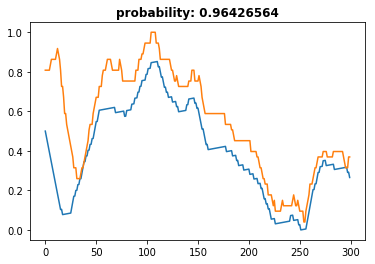

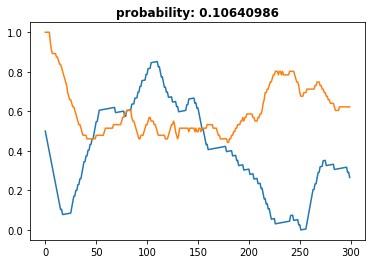

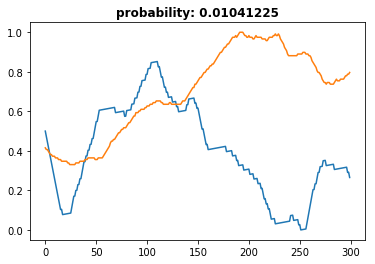

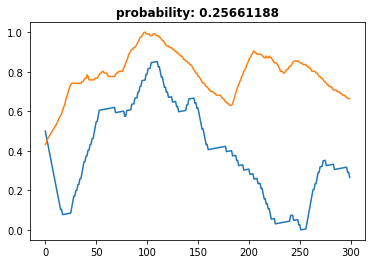

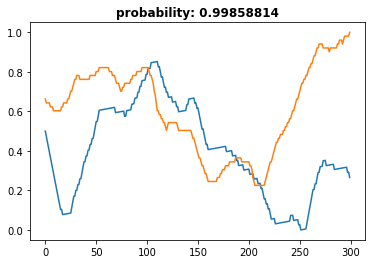

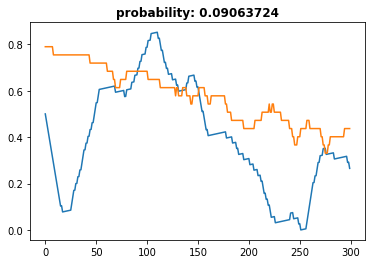

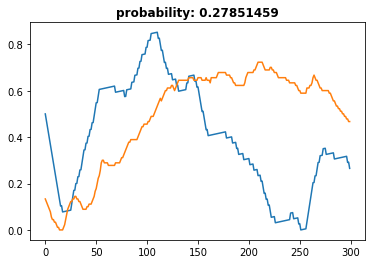

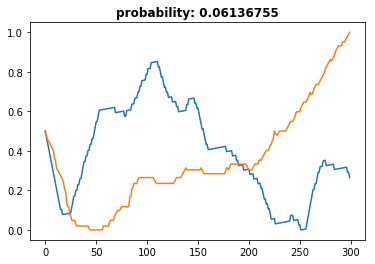

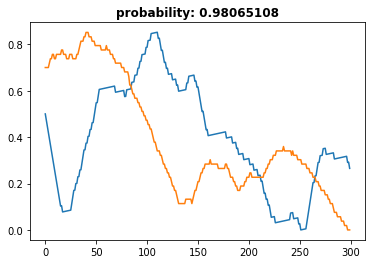

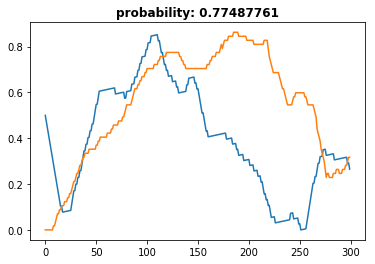

In [20]:
# line probability show
folder_dataset_test = SkylineDataset(root=Config.testing_dir, 
                                transform=transforms.Compose([ToTensor()]))
test_dataloader = DataLoader(folder_dataset_test,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
example0 = next(dataiter)
line0 = example0["line"][0].view(1, 1, -1)
line1 = example0["line"][1].view(1, 1, -1)
label = example0["label"].numpy()
print(label)
for i in range(10):
    output = model(Variable(line0).to(device),Variable(line1).to(device))
    line_show_test((line0, line1, label),'probability: {:.8f}'.format(output.item()))
    
    example1 = next(dataiter)
    line1 = example1["line"][1].view(1, 1, -1)

In [19]:
# acc inference
model.eval()

with torch.no_grad():
    filenames = os.listdir(Config.testing_dir)
    acc_top20 = 0
    acc_top50 = 0
    acc_top100 = 0
    acc_top200 = 0

    for i in trange(100):
        index_target = random.randint(0, len(filenames)-1)
        file0 = read_data_row(os.path.join(Config.testing_dir, filenames[index_target]), 1).strip().split(" ")
        line0 = np.array(list(map(int, file0[0].split(','))))
        dist = []
        for f in filenames:
            file1 = read_data_row(os.path.join(Config.testing_dir, f), 1).strip().split(" ")
            line1 = np.array(list(map(int, file1[1].split(','))))
            line = np.hstack((line0, line1))
            line_min, line_max = line.min(), line.max()
            line = (line-line_min)/(line_max-line_min)
            line1 = torch.from_numpy(line[:300].reshape(1, 1, -1))
            line2 = torch.from_numpy(line[300:].reshape(1, 1, -1))

            output = model(Variable(line1).float().to(device), Variable(line2).float().to(device))
            dist.append(output.item())

        dist = pd.Series(np.array(dist)).sort_values(ascending=False)
        if index_target in dist[:20].index.tolist():
            acc_top20 += 1
        if index_target in dist[:50].index.tolist():
            acc_top50 += 1    
        if index_target in dist[:100].index.tolist():
            acc_top100 += 1
        if index_target in dist[:200].index.tolist():
            acc_top200 += 1

    acc_top20 /= 100.0
    acc_top50 /= 100.0
    acc_top100 /= 100.0
    acc_top200 /= 100.0
    acc_mean = (acc_top20+acc_top50+acc_top100+acc_top200) / 4
    print('acc_top20: %.3f | acc_top50: %.3f | acc_top100: %.3f | acc_top200: %.3f | acc_mean: %.3f' % ( 
                                                                                                acc_top20, 
                                                                                                acc_top50,
                                                                                                acc_top100,
                                                                                                acc_top200,
                                                                                                acc_mean))


 83%|████████▎ | 83/100 [05:54<01:21,  4.82s/it]

KeyboardInterrupt: 